In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv -O jamb_exam_results.csv

--2024-11-02 13:18:59--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-02 13:18:59--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K  --.-KB/s    in 0.02s   

2024-11-02 13:18:59 (16.2 MB/s) - ‘jamb_exam_result

In [3]:
df = pd.read_csv('jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


# Preparing the dataset

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
del df['student_id']
df.fillna(0, inplace=True)

In [5]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=1)

len(df_train), len(df_val), len(df_test)

(3000, 1000, 1000)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values

del df_train['jamb_score']
del df_val['jamb_score']

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Question 1
# Decision Tree

In [7]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



# Question 2
# Random Forest

In [8]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [9]:
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(round(rmse, 2))

42.14


# Question 3
# Tunning n_estimators

In [10]:
scores = []

for n in range(10, 201, 10):
    
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    scores.append((n, round(rmse, 3)))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

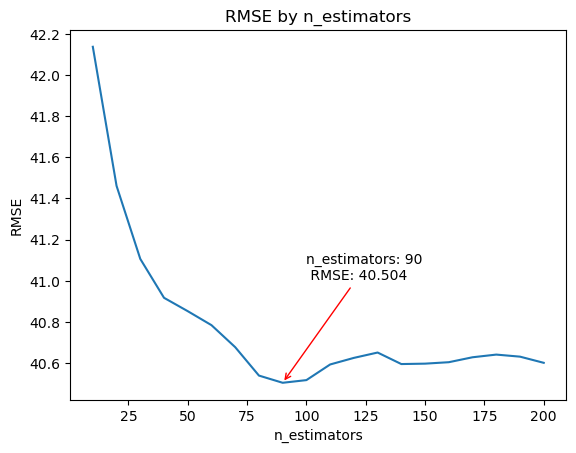

In [11]:
min_rmse_index = df_scores['rmse'].idxmin()
min_rmse_value = df_scores['rmse'].min()
min_rmse_n_estimators = df_scores.loc[min_rmse_index, 'n_estimators']

plt.plot(df_scores['n_estimators'], df_scores['rmse'])
# plt.vlines(min_n_estimators, ymin=df_scores['rmse'].min() - 1, ymax=df_scores['rmse'].max() + 1, colors='red')
# plt.scatter(min_n_estimators, min_rmse_value, color='red', s=100, zorder=5)
plt.annotate(f"n_estimators: {min_rmse_n_estimators}\n RMSE: {min_rmse_value}", xy=(min_rmse_n_estimators, min_rmse_value),
             xytext=(min_rmse_n_estimators + 10, min_rmse_value + 0.5), arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE by n_estimators')
plt.show()

# Question 4
# Tunning max_depth

In [12]:
scores = []

for d in [10, 15, 20, 25]:

    for n in range(10, 201, 10):

        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((d, n, round(rmse, 3)))
    
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

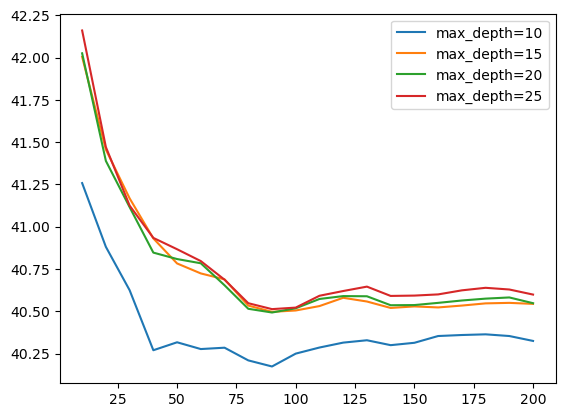

In [13]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

# Question 5
# Feature Importance

In [14]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
feature_importance = pd.Series(rf.feature_importances_, index=dv.get_feature_names_out())
feature_importance.sort_values(ascending=False)

study_hours_per_week                0.248354
attendance_rate                     0.149729
distance_to_school                  0.136486
teacher_quality                     0.082682
age                                 0.069311
assignments_completed               0.031517
socioeconomic_status=High           0.025714
parent_involvement=High             0.022919
it_knowledge=High                   0.017719
parent_education_level=Secondary    0.016957
parent_education_level=Primary      0.015450
parent_education_level=Tertiary     0.014489
extra_tutorials=No                  0.013459
parent_involvement=Low              0.013358
it_knowledge=Low                    0.012404
access_to_learning_materials=No     0.012325
parent_involvement=Medium           0.011492
socioeconomic_status=Low            0.010708
socioeconomic_status=Medium         0.010563
gender=Male                         0.010383
access_to_learning_materials=Yes    0.010262
school_location=Rural               0.009559
gender=Fem

# Question 6
# XGBoost

In [17]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [23]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [24]:
y_pred = model.predict(dval)

mean_squared_error(y_val, y_pred, squared=False)

41.043354592351655